In [204]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import optuna

def calculate_metrics(filtered_df):
    filtered_df['vol diff'] = filtered_df['Volume'].diff()
    filtered_df['Tnov diff'] = filtered_df['Turnover'].diff()
    filtered_df['avg Tick Price'] = filtered_df.apply(
        lambda row: (row['Tnov diff'] / row['vol diff'] / 300) if row['vol diff'] != 0 else np.nan, axis=1
    )
    filtered_df['avg Tick Price'].replace(0, np.nan, inplace=True)
    filtered_df['avg Tick Price'].fillna(method='ffill', inplace=True)
    filtered_df['avg Tick Price'].fillna(method='bfill', inplace=True)
    filtered_df['avg Tick Price Diff'] = filtered_df['avg Tick Price'].diff()
    mean_diff = filtered_df['avg Tick Price Diff'].mean()
    std_diff = filtered_df['avg Tick Price Diff'].std()
    filtered_df['avg Tick Price Diff Z-Score'] = (filtered_df['avg Tick Price Diff'] - mean_diff) / std_diff
    filtered_df['avg Tick Price Diff Z-Score'].fillna(0, inplace=True)
    return filtered_df

def get_buckets_np(data, bucketSize):
    times = data.index.values
    volumes = data['Volume'].values
    zs = data['z'].values
    
    n_buckets = int(np.ceil(np.sum(volumes) / bucketSize))
    buys, sells, bucket_times = np.zeros(n_buckets), np.zeros(n_buckets), np.zeros(n_buckets, dtype='datetime64[ns]')

    current_bucket, volume_accumulated = 0, 0

    for i, volume in enumerate(volumes):
        while volume > 0:
            if volume_accumulated + volume < bucketSize:
                buys[current_bucket] += volume * zs[i]
                sells[current_bucket] += volume * (1 - zs[i])
                volume_accumulated += volume
                volume = 0
            else:
                remaining_volume = bucketSize - volume_accumulated
                buys[current_bucket] += remaining_volume * zs[i]
                sells[current_bucket] += remaining_volume * (1 - zs[i])
                bucket_times[current_bucket] = times[i]
                volume -= remaining_volume
                current_bucket += 1
                volume_accumulated = 0

    return pd.DataFrame({'Buy': buys, 'Sell': sells, 'Time': bucket_times}).set_index('Time')

def calc_vpin(data, bucketSize, window):
    data['z'] = np.random.rand(len(data))
    volumeBuckets = get_buckets_np(data, bucketSize)
    
    volumeBuckets['VPIN'] = abs(volumeBuckets['Buy'] - volumeBuckets['Sell']).rolling(window).mean() / bucketSize
    volumeBuckets['CDF'] = volumeBuckets['VPIN'].rank(pct=True)
    
    return volumeBuckets

def calculate_bands(vpin_data, moving_average_period=20, num_std_dev=2):
    vpin_data['Moving_Average'] = vpin_data['CDF'].rolling(window=moving_average_period).mean()
    vpin_data['Std_Dev'] = vpin_data['CDF'].rolling(window=moving_average_period).std()
    vpin_data['Upper_Band'] = vpin_data['Moving_Average'] + (vpin_data['Std_Dev'] * num_std_dev)
    vpin_data['Lower_Band'] = vpin_data['Moving_Average'] - (vpin_data['Std_Dev'] * num_std_dev)
    return vpin_data

# def calculate_cumulative_returns(vpin_data, initial_capital=1000000, risk_free_rate=0.0):
#     capital = initial_capital
#     position = 0
#     entry_price = 0
#     number_of_shares = 0
#     capital_history = []  # Store daily capital values
    
#     for index, row in vpin_data.iterrows():
#         if position == 0:  # Check if we are not in the market
#             if row['CDF'] >= row['Upper_Band'] and abs(row['avg Tick Price Diff Z-Score']) > 1:
#                 position = 1  # Enter a position
#                 entry_price = row['Last Price']
#                 number_of_shares = capital / entry_price  # Buy shares
#         elif position == 1:  # Check if we need to exit the market
#             if row['CDF'] <= row['Lower_Band']:
#                 exit_price = row['Last Price']
#                 position_return = number_of_shares * (exit_price - entry_price) if row['avg Tick Price Diff'] > 0 else number_of_shares * (entry_price - exit_price)
#                 capital += position_return
#                 position = 0  # Reset position
        
#         capital_history.append(capital)

#     # Convert capital history to DataFrame for further analysis
#     capital_df = pd.DataFrame({'Cumulative Capital': capital_history}, index=vpin_data.index)
#     capital_df['Daily Returns'] = capital_df['Cumulative Capital'].pct_change()
#     mean_daily_return = capital_df['Daily Returns'].mean()
#     std_dev = capital_df['Daily Returns'].std()

#     # Annualize the Sharpe Ratio
#     trading_days = 252
#     annualized_sharpe_ratio = (mean_daily_return - risk_free_rate) / std_dev * np.sqrt(trading_days) if std_dev != 0 else 0

#     return capital_df, annualized_sharpe_ratio

# def calculate_cumulative_returns(vpin_data, initial_capital=1000000, risk_free_rate=0.0):
#     capital = initial_capital
#     position = 0  # 0 means no position, 1 means long, -1 means short
#     entry_price = 0
#     number_of_shares = 0
#     capital_history = []  # Store daily capital values

#     for index, row in vpin_data.iterrows():
#         if position == 0:  # Check if we are not in the market
#             if row['CDF'] >= row['Upper_Band'] and abs(row['avg Tick Price Diff Z-Score']) > 2:
#                 if row['avg Tick Price Diff'] > 0:
#                     position = 1  # Enter a long position
#                 else:
#                     position = -1  # Enter a short position
#                 entry_price = row['Last Price']
#                 number_of_shares = capital / entry_price  # Calculate number of shares based on current capital
#         elif position == 1:  # Check if we need to exit the long position
#             if row['CDF'] <= row['Lower_Band']:
#                 exit_price = row['Last Price']
#                 position_return = number_of_shares * (exit_price - entry_price)
#                 capital += position_return
#                 position = 0  # Reset position
#         elif position == -1:  # Check if we need to exit the short position
#             if row['CDF'] <= row['Lower_Band']:
#                 exit_price = row['Last Price']
#                 position_return = number_of_shares * (entry_price - exit_price)
#                 capital += position_return
#                 position = 0  # Reset position
        
#         capital_history.append(capital)

#     # Convert capital history to DataFrame for further analysis
#     capital_df = pd.DataFrame({'Cumulative Capital': capital_history}, index=vpin_data['Days'])
#     capital_df['Daily Returns'] = capital_df['Cumulative Capital'].pct_change()
#     mean_daily_return = capital_df['Daily Returns'].mean()
#     std_dev = capital_df['Daily Returns'].std()

#     # Annualize the Sharpe Ratio
#     trading_days = 252
#     annualized_sharpe_ratio = (mean_daily_return - risk_free_rate) / std_dev * np.sqrt(trading_days) if std_dev != 0 else 0

#     return capital_df, annualized_sharpe_ratio
def calculate_cumulative_returns(vpin_data, initial_capital=1000000, risk_free_rate=0.0):
    capital = initial_capital
    position = 0  # 0 means no position, 1 means long, -1 means short
    entry_price = 0
    number_of_shares = 0
    capital_history = []  # Store daily capital values
    buy_signals = []
    sell_signals = []

    for index, row in vpin_data.iterrows():
        if position == 0:  # Check if we are not in the market
            if row['CDF'] >= row['Upper_Band'] and abs(row['avg Tick Price Diff Z-Score']) > 1:
                if row['avg Tick Price Diff'] > 0:
                    position = 1  # Enter a long position
                    buy_signals.append((index, row['Last Price']))
                else:
                    position = -1  # Enter a short position
                    sell_signals.append((index, row['Last Price']))
                entry_price = row['Last Price']
                number_of_shares = capital / entry_price  # Calculate number of shares based on current capital
        elif position == 1:  # Check if we need to exit the long position
            if row['CDF'] <= row['Lower_Band']:
                exit_price = row['Last Price']
                position_return = number_of_shares * (exit_price - entry_price)
                capital += position_return
                position = 0  # Reset position
                sell_signals.append((index, row['Last Price']))
        elif position == -1:  # Check if we need to exit the short position
            if row['CDF'] <= row['Lower_Band']:
                exit_price = row['Last Price']
                position_return = number_of_shares * (entry_price - exit_price)
                capital += position_return
                position = 0  # Reset position
                buy_signals.append((index, row['Last Price']))
        
        capital_history.append(capital)

    # Convert capital history to DataFrame for further analysis
    capital_df = pd.DataFrame({'Cumulative Capital': capital_history}, index=vpin_data.index)
    capital_df['Daily Returns'] = capital_df['Cumulative Capital'].pct_change()
    mean_daily_return = capital_df['Daily Returns'].mean()
    std_dev = capital_df['Daily Returns'].std()

    # Annualize the Sharpe Ratio
    trading_days = 252
    annualized_sharpe_ratio = (mean_daily_return - risk_free_rate) / std_dev * np.sqrt(trading_days) if std_dev != 0 else 0

    return capital_df, annualized_sharpe_ratio

def record_trading_signals(vpin_data):
    position = 0  # 0 means no position, 1 means long, -1 means short
    buy_signals = []
    sell_signals = []

    for index, row in vpin_data.iterrows():
        if position == 0:  # Check if we are not in the market
            if row['CDF'] >= row['Upper_Band'] and abs(row['avg Tick Price Diff Z-Score']) > 1:
                if row['avg Tick Price Diff'] > 0:
                    position = 1  # Enter a long position
                    buy_signals.append((index, row['Last Price']))
                else:
                    position = -1  # Enter a short position
                    sell_signals.append((index, row['Last Price']))
        elif position == 1:  # Check if we need to exit the long position
            if row['CDF'] <= row['Lower_Band']:
                position = 0  # Reset position
                sell_signals.append((index, row['Last Price']))
        elif position == -1:  # Check if we need to exit the short position
            if row['CDF'] <= row['Lower_Band']:
                position = 0  # Reset position
                buy_signals.append((index, row['Last Price']))

    return buy_signals, sell_signals

def process_vpin_data(vpin_data, filtered_df_1229):
    # Drop the last row from the DataFrame
    vpin_data = vpin_data.drop(vpin_data.index[-1])

    # Ensure CDF column is cleaned or preprocessed to remove NaN values
    vpin_data = vpin_data.dropna(subset=['CDF'])
    vpin_data = vpin_data.drop_duplicates()

    # Add 'Days' column
    vpin_data['Days'] = range(1, len(vpin_data) + 1)

    # Perform asof merge with 'avg Tick Price Diff Z-Score'
    vpin_data = pd.merge_asof(vpin_data, filtered_df_1229[['avg Tick Price Diff Z-Score']],
                              left_index=True, right_index=True, direction='nearest')
    vpin_data.rename(columns={'avg Tick Price Diff Z-Score': 'avg Tick Price Diff Z-Score'}, inplace=True)

    # Perform asof merge with 'LastPrice'
    vpin_data = pd.merge_asof(vpin_data, filtered_df_1229[['LastPrice']],
                              left_index=True, right_index=True, direction='nearest')
    vpin_data.rename(columns={'LastPrice': 'Last Price'}, inplace=True)

    # Perform asof merge with 'avg Tick Price Diff'
    vpin_data = pd.merge_asof(vpin_data, filtered_df_1229[['avg Tick Price Diff']],
                              left_index=True, right_index=True, direction='nearest')
    vpin_data.rename(columns={'avg Tick Price Diff': 'avg Tick Price Diff'}, inplace=True)

    return vpin_data

def objective(trial):
    bucketSize = trial.suggest_int('bucketSize', 1000000, 2000000)
    window = trial.suggest_int('window', 10, 100)
    z_score_threshold = trial.suggest_float('z_score_threshold', 0.5, 3.0)
    moving_average_period = trial.suggest_int('moving_average_period', 5, 50)
    num_std_dev = trial.suggest_int('num_std_dev', 1, 3)

    VPIN_data = filtered_df_1229.copy()

    VPIN_data = calc_vpin(VPIN_data, bucketSize, window)
    VPIN_data = calculate_bands(VPIN_data, moving_average_period, num_std_dev)
    VPIN_data = process_vpin_data(VPIN_data, filtered_df_1229)

    cumulative_return_df, sharpe_ratio = calculate_cumulative_returns(VPIN_data)

    return sharpe_ratio

# Assuming combined_df is already loaded with the data and 'Updated_Time' is set as the index
#Read combined_df
combined_df = pd.read_csv('/Users/yanchuz/Downloads/combined_df.csv')
combined_df['Updated_Time'] = pd.to_datetime(combined_df['Updated_Time'])
combined_df.set_index('Updated_Time', inplace=True)

# Filter the DataFrame for entries only from December 29, 2023
filtered_df_1229 = combined_df[combined_df.index.date == pd.Timestamp('2023-12-29').date()]

# Apply the function to filtered_df_1229
filtered_df_1229 = calculate_metrics(filtered_df_1229)

# Run the optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Get the best parameters
best_params = study.best_trial.params

# Apply the best parameters to calculate VPIN and process data
bucketSize = best_params['bucketSize']
window = best_params['window']
z_score_threshold = best_params['z_score_threshold']
moving_average_period = best_params['moving_average_period']
num_std_dev = best_params['num_std_dev']

VPIN_data = filtered_df_1229.copy()
VPIN_data = calc_vpin(VPIN_data, bucketSize, window)
VPIN_data = calculate_bands(VPIN_data, moving_average_period, num_std_dev)
VPIN_data = process_vpin_data(VPIN_data, filtered_df_1229)

# Calculate cumulative returns and Sharpe ratio with best parameters
cumulative_return_df, sharpe_ratio = calculate_cumulative_returns(VPIN_data)




<ipython-input-204-4eccc2b9cad9>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['vol diff'] = filtered_df['Volume'].diff()
<ipython-input-204-4eccc2b9cad9>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Tnov diff'] = filtered_df['Turnover'].diff()
<ipython-input-204-4eccc2b9cad9>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

In [216]:

print(best_params)
# Apply the best parameters to calculate VPIN and process data
bucketSize = best_params['bucketSize']
window = best_params['window']
z_score_threshold = best_params['z_score_threshold']
moving_average_period = best_params['moving_average_period']
num_std_dev = best_params['num_std_dev']

VPIN_data = filtered_df_1229.copy()
VPIN_data = calc_vpin(VPIN_data, bucketSize, window)
VPIN_data = calculate_bands(VPIN_data, moving_average_period, num_std_dev)
VPIN_data = process_vpin_data(VPIN_data, filtered_df_1229)

# Calculate cumulative returns and Sharpe ratio with best parameters
cumulative_return_df, sharpe_ratio = calculate_cumulative_returns(VPIN_data)
print(sharpe_ratio)



{'bucketSize': 1395445, 'window': 64, 'z_score_threshold': 2.1468685244520667, 'moving_average_period': 36, 'num_std_dev': 2}
1.072749138736107


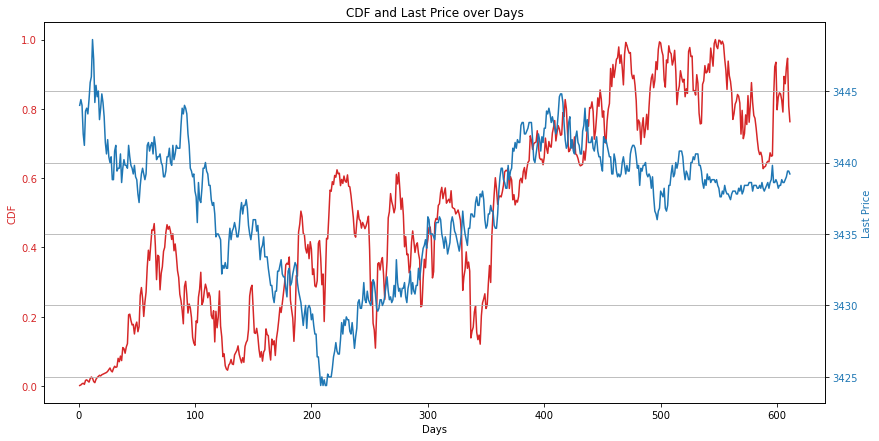

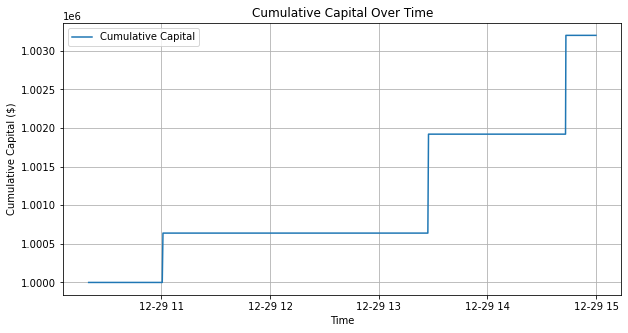

Time
2023-12-29 10:19:52.900    1.000000e+06
2023-12-29 10:20:23.400    1.000000e+06
2023-12-29 10:20:59.400    1.000000e+06
2023-12-29 10:21:31.400    1.000000e+06
2023-12-29 10:22:01.900    1.000000e+06
                               ...     
2023-12-29 14:59:10.900    1.003201e+06
2023-12-29 14:59:21.900    1.003201e+06
2023-12-29 14:59:32.900    1.003201e+06
2023-12-29 14:59:43.900    1.003201e+06
2023-12-29 14:59:54.900    1.003201e+06
Name: Cumulative Capital, Length: 611, dtype: float64
Sharpe Ratio: 1.07


In [217]:
# Create a new figure and a subplot with a first y-axis
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plotting the CDF on the first y-axis
color = 'tab:red'
ax1.set_xlabel('Days')
ax1.set_ylabel('CDF', color=color)
ax1.plot(VPIN_data['Days'], VPIN_data['CDF'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Creating a second y-axis to plot the Last Price
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Last Price', color=color)  # we already handled the x-label with ax1
ax2.plot(VPIN_data['Days'], VPIN_data['Last Price'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Adding title and grid
plt.title('CDF and Last Price over Days')
plt.grid(True)

# Show the plot
plt.show()

# # Plot Last Price and CDF
# plt.figure(figsize=(14, 7))
# plt.plot(VPIN_data['Days'], VPIN_data['Last Price'], label='Last Price')
# plt.plot(VPIN_data['Days'], VPIN_data['CDF'], label='CDF', color='orange')
# plt.title('Last Price and CDF')
# plt.legend()
# plt.show()

# Plot Cumulative Capital
plt.figure(figsize=(10, 5))
plt.plot(cumulative_return_df.index, cumulative_return_df['Cumulative Capital'], label='Cumulative Capital')
plt.title('Cumulative Capital Over Time')
plt.xlabel('Time')
plt.ylabel('Cumulative Capital ($)')
plt.legend()
plt.grid(True)
plt.show()
print(cumulative_return_df['Cumulative Capital'])
# Print Annualized Return, Cumulative Return, and Sharpe Ratio
# print(f"Annualized Return: {(cumulative_return ** 252-1)*100:.2f}%")
#print(f"Cumulative Return: {(cumulative_return-1) * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

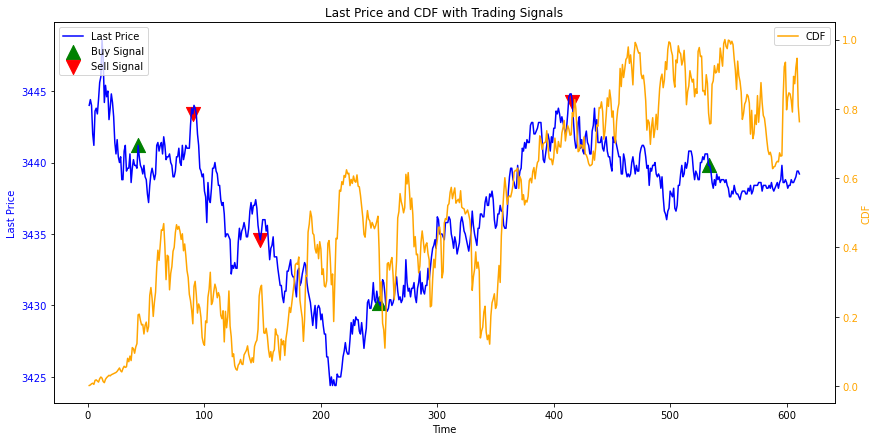

In [229]:
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot Last Price on ax1
ax1.plot(VPIN_data['Days'], VPIN_data['Last Price'], label='Last Price', color='blue')
ax1.set_xlabel('Time')
ax1.set_ylabel('Last Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Plot buy and sell signals on ax1
buy_signals_dates, buy_signals_prices = zip(*[(VPIN_data.loc[date, 'Days'], price) for date, price in buy_signals]) if buy_signals else ([], [])
sell_signals_dates, sell_signals_prices = zip(*[(VPIN_data.loc[date, 'Days'], price) for date, price in sell_signals]) if sell_signals else ([], [])

ax1.scatter(buy_signals_dates, buy_signals_prices, marker='^', color='green', label='Buy Signal', s=200, alpha=1)
ax1.scatter(sell_signals_dates, sell_signals_prices, marker='v', color='red', label='Sell Signal',s=200, alpha=1)

# Create another y-axis for the CDF on ax2
ax2 = ax1.twinx()
ax2.plot(VPIN_data['Days'], VPIN_data['CDF'], label='CDF', color='orange')
ax2.set_ylabel('CDF', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title('Last Price and CDF with Trading Signals')
plt.show()


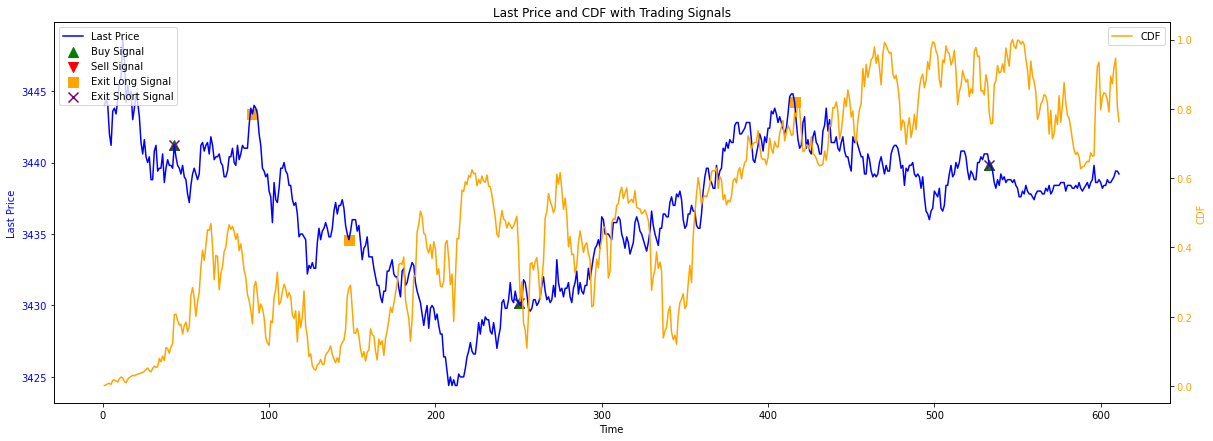

In [228]:
fig, ax1 = plt.subplots(figsize=(20, 7))

# Plot Last Price on ax1
ax1.plot(VPIN_data['Days'], VPIN_data['Last Price'], label='Last Price', color='blue')
ax1.set_xlabel('Time')
ax1.set_ylabel('Last Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Plot buy, sell, and exit signals on ax1
buy_signals_dates, buy_signals_prices = zip(*[(VPIN_data.loc[date, 'Days'], price) for date, price in buy_signals]) if buy_signals else ([], [])
sell_signals_dates, sell_signals_prices = zip(*[(VPIN_data.loc[date, 'Days'], price) for date, price in sell_signals]) if sell_signals else ([], [])

# Assuming exit signals are same as sell_signals for long and buy_signals for short
exit_long_signals_dates, exit_long_signals_prices = sell_signals_dates, sell_signals_prices
exit_short_signals_dates, exit_short_signals_prices = buy_signals_dates, buy_signals_prices

ax1.scatter(buy_signals_dates, buy_signals_prices, marker='^', color='green', label='Buy Signal', s=100, alpha=1)
ax1.scatter(sell_signals_dates, sell_signals_prices, marker='v', color='red', label='Sell Signal', s=100, alpha=1)
ax1.scatter(exit_long_signals_dates, exit_long_signals_prices, marker='s', color='orange', label='Exit Long Signal', s=100, alpha=1)
ax1.scatter(exit_short_signals_dates, exit_short_signals_prices, marker='x', color='purple', label='Exit Short Signal', s=100, alpha=1)

# Create another y-axis for the CDF on ax2
ax2 = ax1.twinx()
ax2.plot(VPIN_data['Days'], VPIN_data['CDF'], label='CDF', color='orange')
ax2.set_ylabel('CDF', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title('Last Price and CDF with Trading Signals')
plt.show()
